This notebook is designed to demonstrate the following,

1. How to use TensorFlow script mode.
2. How to use SageMaker Debugger to save Tensors
3. How to save data for TensorBoard ()
4. How to create a Trial
5. How to get Tensor data and visualize it.

In [ ]:
!  python -m pip install smdebug

In [1]:
entry_point_script = 'sm-tf2-keras-hook-non-eager.py'

In [2]:
import boto3
import os
import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig, TensorBoardOutputConfig, Rule, rule_configs


sagemaker_session = sagemaker.Session()
BUCKET_NAME = "ml-pipeline-1511"
LOCATION_IN_BUCKET = 'smdebug-tf'

s3_bucket_for_tensors = 's3://{BUCKET_NAME}/{LOCATION_IN_BUCKET}'.format(BUCKET_NAME=BUCKET_NAME, LOCATION_IN_BUCKET=LOCATION_IN_BUCKET)

tb_config = TensorBoardOutputConfig('s3://ml-pipeline-1511/tensorboard')

cnf = DebuggerHookConfig(
                      s3_output_path=s3_bucket_for_tensors,  
                      collection_configs=[
                        CollectionConfig(
                            name="all",
                            parameters={
                                "include_regex": ".*",
                                "save_interval": "100"
                            }
                        )
                     ]
                )

estimator = TensorFlow(
    role=sagemaker.get_execution_role(),
    base_job_name='smdebug-sm-tf',
    train_instance_count=1,
    train_instance_type='ml.m5.xlarge',
    entry_point = entry_point_script ,
    framework_version='2.1.0',
    py_version='py3',
    train_max_run=3600,
    script_mode=True,
    debugger_hook_config = cnf,
    tensorboard_output_config=tb_config    
    
)

In [3]:
estimator.fit(wait=True)

2020-05-14 08:33:28 Starting - Starting the training job...
2020-05-14 08:33:30 Starting - Launching requested ML instances...
2020-05-14 08:34:26 Starting - Preparing the instances for training......
2020-05-14 08:35:23 Downloading - Downloading input data...
2020-05-14 08:35:57 Training - Training image download completed. Training in progress.
2020-05-14 08:35:57 Uploading - Uploading generated training model2020-05-14 08:35:50,613 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-05-14 08:35:50,621 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-14 08:35:50,885 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-14 08:35:50,901 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-14 08:35:50,915 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-14 08:35:50,925 sagemaker-containers INFO     Invoking user 

In [72]:
job_name = estimator.latest_training_job.name
#job_name = 'smdebug-sm-tf-2020-04-17-07-09-35-182'
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)


In [78]:
path = estimator.latest_job_debugger_artifacts_path()
print('Tensors are stored in: ', path)

Tensors are stored in:  s3://ml-pipeline-1511/smdebug-tf/smdebug-sm-tf-2020-05-13-15-45-38-578/debug-output


In [80]:
# inspect tensors saved in conv0_tensors collection (for conv0 layer of our model)
from smdebug.trials import create_trial

s3_output_path = "s3://ml-pipeline-1511/smdebug-tf/smdebug-sm-tf-2020-05-13-15-45-38-578/debug-output"

#s3_output_path = path

trial = create_trial(s3_output_path)


[2020-05-13 15:49:19.609 ip-172-16-10-133:17269 INFO s3_trial.py:42] Loading trial debug-output at path s3://ml-pipeline-1511/smdebug-tf/smdebug-sm-tf-2020-05-13-15-45-38-578/debug-output


In [81]:
trial.tensor_names

[2020-05-13 15:49:23.270 ip-172-16-10-133:17269 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-05-13 15:49:24.287 ip-172-16-10-133:17269 INFO trial.py:210] Loaded all steps


<bound method Trial.tensor_names of <smdebug.trials.s3_trial.S3Trial object at 0x7f63a7bd0f60>:(
    name=debug-output,
    path=s3://ml-pipeline-1511/smdebug-tf/smdebug-sm-tf-2020-05-13-15-45-38-578/debug-output/,
    steps=[0, 31, 63, 95, 100, 127, 159, 191, 200, 223, 255, 287, 300, 319],
    collections=['outputs', 'losses', 'weights', 'gradients', 'default', 'all', 'optimizer_variables', 'metrics', 'biases', 'sm_metrics', 'inputs'],
    tensor_names=['accuracy', 'batch', 'dense/outputs/dense/Relu:0', 'dense/weights/dense/bias:0', 'dense/weights/dense/kernel:0', 'dense_1/outputs/dense_1/Relu:0', 'dense_1/weights/dense_1/bias:0', 'dense_1/weights/dense_1/kernel:0', 'dense_2/outputs/dense_2/BiasAdd:0', 'dense_2/weights/dense_2/bias:0', 'dense_2/weights/dense_2/kernel:0', 'loss', 'size', 'training/Adam/beta_1:0', 'training/Adam/beta_2:0', 'training/Adam/decay:0', 'training/Adam/gradients/gradients/dense/BiasAdd_grad/BiasAddGrad:0', 'training/Adam/gradients/gradients/dense/MatMul_grad/M

In [82]:
trial.collection('gradients').tensor_names

{'training/Adam/gradients/gradients/dense/BiasAdd_grad/BiasAddGrad:0',
 'training/Adam/gradients/gradients/dense/MatMul_grad/MatMul_1:0',
 'training/Adam/gradients/gradients/dense_1/BiasAdd_grad/BiasAddGrad:0',
 'training/Adam/gradients/gradients/dense_1/MatMul_grad/MatMul_1:0',
 'training/Adam/gradients/gradients/dense_2/BiasAdd_grad/BiasAddGrad:0',
 'training/Adam/gradients/gradients/dense_2/MatMul_grad/MatMul_1:0'}

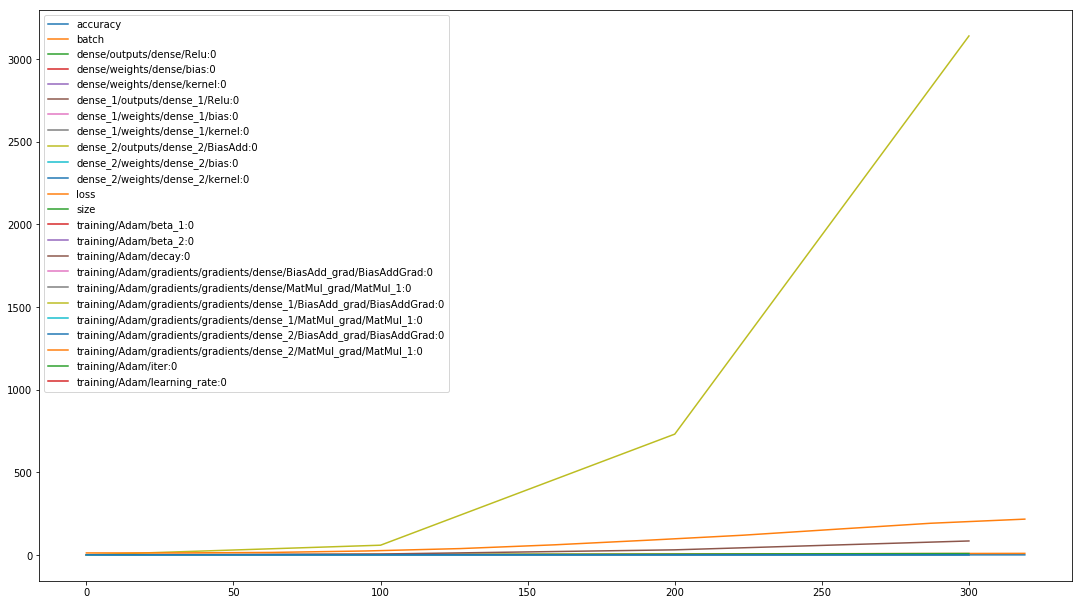

In [83]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 

def get_data(trial, tname):
    #print(tname)
    tensor = trial.tensor(tname)
    #print(tensor)
    steps = tensor.steps()
    vals = []
    for s in steps:
        val = tensor.value(s)
        val = np.mean(np.abs(val))
        vals.append(val)        
    return steps,vals

def plot_tensors(lt,ttype):
    for tname in lt.tensor_names(regex=ttype):
        #lst = ['dense/weights/sequential/dense/kernel:0', 'dense_1/weights/sequential/dense_1/kernel:0','dense_2/weights/sequential/dense_2/kernel:0']
        #print(tname)
        #if not tname in lst: continue
        steps, data = get_data(lt, tname)
        plt.plot(steps, data, label=tname)
        
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)    
    plt.legend()
    plt.show()
        

plot_tensors(trial,".*") 

    
    